In [2]:
!pip install keras-tuner
# pip install tensorflow-addons
# !pip install tensorflow-addons



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from keras_tuner.tuners import RandomSearch
from sklearn.utils import class_weight
import tensorflow as tf
import logging
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L2

from tensorflow.keras.metrics import Precision, Recall

In [6]:
# Set up logging
logging.basicConfig(filename='final_log.log', level=logging.INFO)

In [7]:
def scale_dataframe(df_scalable):
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_scalable), columns=df_scalable.columns, index=df_scalable.index)
    return df_scaled

In [8]:
df = pd.read_csv('reduced_testing.csv')
df_target = pd.read_csv('testing_target.csv', index_col=False)
df__feature_scaled = scale_dataframe(df)
df = df__feature_scaled.reset_index()
dff = df_target.reset_index()
df1 = pd.merge(dff, df, on="index", how="inner")
df = df1.drop(columns=["index",'Unnamed: 0_x','Unnamed: 0_y'])
df = df.dropna()

FileNotFoundError: [Errno 2] No such file or directory: 'testing_target.csv'

In [9]:
df["target"].value_counts()

KeyError: 'target'

In [6]:
# Assuming the target column is named 'target' and other columns are feature columns
X = df.drop('target', axis=1).values
y = df['target'].values

# Check for NaNs and Infs in the dataset
if np.any(np.isnan(X)) or np.any(np.isnan(y)):
    raise ValueError("Input data contains NaN values. Please clean the dataset.")
if np.any(np.isinf(X)) or np.any(np.isinf(y)):
    raise ValueError("Input data contains infinite values. Please clean the dataset.")

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Encode labels to non-negative integers (e.g., map -1 -> 0, 0 -> 1, 1 -> 2)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Converts -1 to 0, 0 to 1, 1 to 2
y_test_encoded = label_encoder.transform(y_test)

In [32]:
# Encode labels to non-negative integers (e.g., map -1 -> 0, 0 -> 1, 1 -> 2)
label_encoder = LabelEncoder()
y_t = label_encoder.fit_transform(y)  # Converts -1 to 0, 0 to 1, 1 to 2
# y_test_encoded = label_encoder.transform(y_test)

In [9]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Debug: Print the shape of the input data
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (8548, 60)
Shape of X_test: (2138, 60)


In [11]:
# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = {i: class_weights[i] for i in range(len(np.unique(y_train_encoded)))}

In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall

# Custom F1 score metric using built-in precision and recall
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        # Initialize the precision and recall metrics
        self.precision = Precision(name='precision')
        self.recall = Recall(name='recall')
        self.f1 = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update precision and recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        # Compute F1 score
        precision = self.precision.result()
        recall = self.recall.result()
        self.f1.assign(2 * ((precision * recall) / (precision + recall + K.epsilon())))

    def result(self):
        return self.f1

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1.assign(0.0)




In [13]:
# Custom metrics to track each class's accuracy
def class_accuracy(y_true, y_pred, target_class):
    y_pred_class = tf.math.argmax(y_pred, axis=1)
    y_true_class = tf.cast(tf.equal(y_true, target_class), tf.int32)
    y_pred_class = tf.cast(tf.equal(y_pred_class, target_class), tf.int32)
    correct_predictions = tf.reduce_sum(tf.cast(tf.equal(y_true_class, y_pred_class), tf.float32))
    total_class_count = tf.reduce_sum(tf.cast(y_true_class, tf.float32))
    return correct_predictions / (total_class_count + tf.keras.backend.epsilon())

In [14]:
def sparse_precision(y_true, y_pred):
    y_pred_class = tf.argmax(y_pred, axis=1)
    true_positives = tf.reduce_sum(tf.cast(tf.equal(y_pred_class, tf.cast(y_true, tf.int64)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(tf.greater_equal(y_pred_class, 0), tf.float32))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [15]:
def sparse_recall(y_true, y_pred):
    y_pred_class = tf.argmax(y_pred, axis=1)
    true_positives = tf.reduce_sum(tf.cast(tf.equal(y_pred_class, tf.cast(y_true, tf.int64)), tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(tf.greater_equal(y_true, 0), tf.float32))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

In [16]:
# Define a custom callback to log class-wise accuracy
class LoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Get predictions
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        
        # Calculate class-wise accuracies
        acc_0 = class_accuracy(y_val, y_pred, 0).numpy()
        acc_1 = class_accuracy(y_val, y_pred, 1).numpy()
        acc_2 = class_accuracy(y_val, y_pred, 2).numpy()  # For encoded class '2', which originally was '-1'

        logging.info(f"Epoch {epoch + 1}: Loss = {logs['loss']}, Accuracy = {logs['accuracy']}, "
                     f"Val Loss = {logs['val_loss']}, Val Accuracy = {logs['val_accuracy']}, "
                     f"Class 0 Accuracy = {acc_0}, Class 1 Accuracy = {acc_1}, Class 2 (original -1) Accuracy = {acc_2}")
        print(f"Epoch {epoch + 1}: Loss = {logs['loss']}, Accuracy = {logs['accuracy']}, "
                     f"Val Loss = {logs['val_loss']}, Val Accuracy = {logs['val_accuracy']}, "
                     f"Class 0 Accuracy = {acc_0}, Class 1 Accuracy = {acc_1}, Class 2 (original -1) Accuracy = {acc_2}")


In [17]:
def exponential_decay(epoch, lr):
    if epoch < 7 :
        return lr
    else:
        return lr * 0.9




In [17]:
# Define batch size variable
batch_size = 128  # You can modify this value for batch size as needed

# Define the model
def build_model(input_dim):
    model = Sequential()
    
    # Input layer and first hidden layer with 80 neurons and linear activation
    model.add(Dense(80, activation='linear', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    # Second hidden layer with 80 neurons and swish activation
    model.add(Dense(80, activation='swish',kernel_regularizer=L2(0.02)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    # Output layer with 3 neurons and softmax activation
    model.add(Dense(3, activation='softmax'))
    

    # Compile The Model With Built-In Metrics
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['Accuracy'])
    return model

# EarlyStopping callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Learning rate scheduler callback for diminishing learning rate
lr_scheduler = LearningRateScheduler(exponential_decay)

# Create an instance of LoggingCallback with validation data
# logging_callback = LoggingCallback(validation_data=(X_test, y_test_encoded))

Input_dim = X_train.shape[1]  # Replace With The Actual Number Of Input Features In Your Data
model = build_model(Input_dim)
# Assuming you have the class weights and other setup ready
history = model.fit(
    X_train, 
    y_train_encoded, 
    validation_data=(X_test, y_test_encoded),
    epochs=50, 
    batch_size=batch_size, 
    class_weight=class_weights_dict,  # If using class weights
    callbacks=[early_stopping, lr_scheduler]
)

2024-09-24 07:06:29.624687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-24 07:06:29.712987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-24 07:06:29.713197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/50


2024-09-24 07:06:44.976586: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f17fc349710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-24 07:06:44.976659: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-24 07:06:45.442863: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-24 07:06:47.314606: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1727161607.794770     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1046/1046 [==============================] - 18s 5ms/step - loss: 2.0975 - Accuracy: 0.5127 - val_loss: 1.5164 - val_Accuracy: 0.5740 - lr: 5.0000e-04
Epoch 2/50
1046/1046 [==============================] - 5s 4ms/step - loss: 1.3707 - Accuracy: 0.6061 - val_loss: 1.1087 - val_Accuracy: 0.6689 - lr: 5.0000e-04
Epoch 3/50
1046/1046 [==============================] - 5s 4ms/step - loss: 1.1476 - Accuracy: 0.6283 - val_loss: 1.0283 - val_Accuracy: 0.6170 - lr: 5.0000e-04
Epoch 4/50
1046/1046 [==============================] - 5s 4ms/step - loss: 1.0530 - Accuracy: 0.6409 - val_loss: 0.9438 - val_Accuracy: 0.6758 - lr: 5.0000e-04
Epoch 5/50
1046/1046 [==============================] - 5s 4ms/step - loss: 1.0088 - Accuracy: 0.6559 - val_loss: 0.8822 - val_Accuracy: 0.7004 - lr: 5.0000e-04
Epoch 6/50
1046/1046 [==============================] - 5s 5ms/step - loss: 0.9853 - Accuracy: 0.6609 - val_loss: 0.8441 - val_Accuracy: 0.7153 - lr: 5.0000e-04
Epoch 7/50
1046/1046 [======================

In [18]:
model.save('feed_forward_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
from tensorflow.keras.models import load_model

# Load the saved model
saved_model = load_model('feed_forward_model.h5')


2024-09-27 10:07:36.148550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-27 10:07:36.180943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-27 10:07:36.181146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [35]:
# Evaluate the model on test data
test_loss, test_accuracy = saved_model.evaluate(X, y, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: nan
Test Accuracy: 0.0111


In [37]:
nvcc --version



NameError: name 'nvcc' is not defined

In [39]:
!pip install nvcc

ERROR: Could not find a version that satisfies the requirement nvcc (from versions: none)
ERROR: No matching distribution found for nvcc


In [19]:
import numpy as np

# Make predictions on the test set
y_pred_probs = saved_model.predict(X)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)


334/334 [==============================] - 4s 969us/step


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

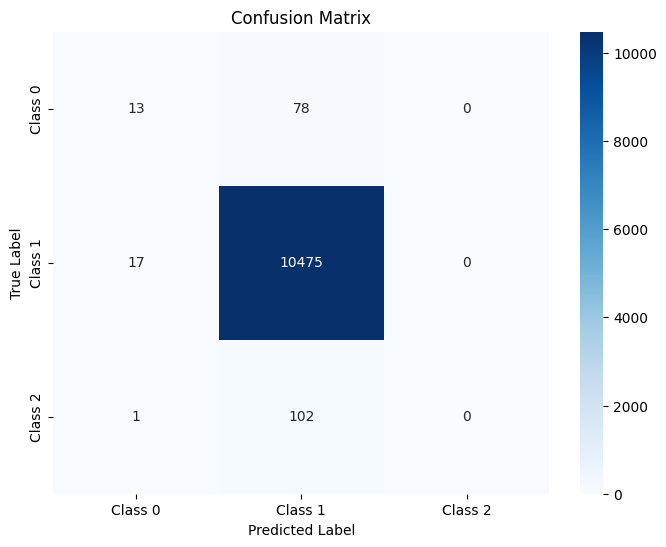

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_t, y_pred)

# Define class names
class_names = ['Class 0', 'Class 1', 'Class 2']  # Replace with your actual class names

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
sduhfj  ---- same different models
P1----- different way 
P0 ---- same nifty50 check